In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/approach1_maskrcnn
!pwd

/content/drive/My Drive/approach1_maskrcnn
/content/drive/My Drive/approach1_maskrcnn


In [3]:
!pip install libtiff
#!pip install MRCNN

     |████████████████████████████████| 133kB 2.8MB/s 
  Created wheel for libtiff: filename=libtiff-0.4.2-cp36-cp36m-linux_x86_64.whl size=280181 sha256=48ce6f890fa9cb14e5923193518f12020f4e42f3e9be82ae80d9bb6cdf20a402
  Stored in directory: /root/.cache/pip/wheels/7c/ce/79/9c7115224f798f73bdbd2c23e06c6fa048adcca7041b9fd104
Successfully built libtiff


In [0]:
from pre_stab import tiff_to_image_array, create_gif
from libtiff import TIFF, TIFFfile
import matplotlib.pyplot as plt
import numpy as np
import imageio
import cv2 
import os
import os.path

In [0]:
# transform original tiff file to frame images
tiff_to_image_array('GFC_505nm_40X1p15NA_PCO_500usexp_160fps_3@0001.tif', '/content/drive/My Drive/approach1_maskrcnn/s2/', '.png')

In [0]:
# transform frame images to gif file
create_gif('s2v.gif', '/content/drive/My Drive/approach1_maskrcnn/s2', duration = 0.1428571)

In [24]:
 
# Read input video
cap = cv2.VideoCapture('s2v.gif')
 
# Get frame count
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
 
# Get width and height of video stream
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the codec for output video
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
 
# Set up output video
#out = cv2.VideoWriter('video_out.mp4', fourcc, fps, (w, h))

print(n_frames)
print(w,h,fps)


100
1280 812 7


In [0]:
# Read first frame
_, prev = cap.read()
print(prev.shape)

In [0]:
# Read first frame
_, prev = cap.read()
# Convert frame to grayscale
prev_gray1 = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
# Pre-define transformation-store array
transforms = np.zeros((n_frames-1, 3), np.float32)
for i in range(n_frames-1):  
    prev_gray=prev_gray1[150:450,250:850] 
    # Detect feature points in previous frame
    prev_pts = cv2.goodFeaturesToTrack(prev_gray,maxCorners=200,qualityLevel=0.5,minDistance=20,blockSize=10)
    '''
    plt.subplot(1,2,1)
    plt.imshow(prev_gray1)
    plt.scatter(prev_pts[:,:,0],prev_pts[:,:,1],c='red')
    plt.subplot(1,2,2)
    plt.imshow(prev_gray1)
    plt.show()
    '''

    # Read next frame
    success, curr1 = cap.read()
    if not success:
        print('END!')
        break

    # Convert to grayscale
    curr_gray1 = cv2.cvtColor(curr1, cv2.COLOR_BGR2GRAY)
    curr_gray=curr_gray1[150:450,250:850]

    # Calculate optical flow (i.e. track feature points)
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)

    # Sanity check
    assert prev_pts.shape == curr_pts.shape

    # Filter only valid points
    idx = np.where(status==1)[0]
    prev_pts = prev_pts[idx]
    curr_pts = curr_pts[idx]

    #Find transformation matrix
    m,inliers = cv2.estimateAffinePartial2D(prev_pts, curr_pts)

    # Extract translation
    dx = m[0,2]
    dy = m[1,2]

    # Extract rotation angle
    da = np.arctan2(m[1,0], m[0,0])

    # Store transformation
    transforms[i] = [dx,dy,da]

    # Move to next frame
    prev_gray1 = curr_gray1
    #print("Frame: " + str(i+1) +  "/" + str(n_frames) + " -  Tracked points : " + str(len(prev_pts)))

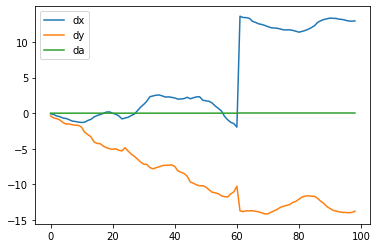

In [26]:
# Compute trajectory using cumulative sum of transformations
trajectory = np.cumsum(transforms, axis=0)
plt.plot(trajectory[:,0],label='dx')
plt.plot(trajectory[:,1],label='dy')
plt.plot(trajectory[:,2],label='da')
plt.legend()
plt.show()

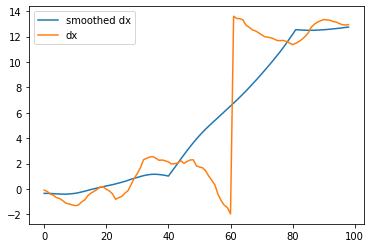

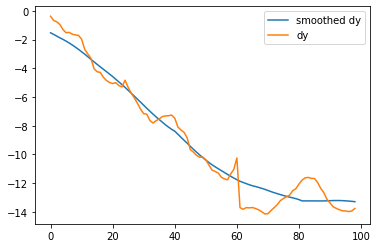

In [27]:
def movingAverage(curve, radius):
    window_size = 2 * radius + 1
    # Define the filter
    f = np.ones(window_size)/window_size
    # Add padding to the boundaries
    curve_pad = np.lib.pad(curve, (radius, radius), 'edge')
    # Apply convolution
    curve_smoothed = np.convolve(curve_pad, f, mode='same')
    # Remove padding
    curve_smoothed = curve_smoothed[radius:-radius]
    # return smoothed curve
    return curve_smoothed

def smooth(trajectory,SMOOTHING_RADIUS):
    smoothed_trajectory = np.copy(trajectory)
    # Filter the x, y and angle curves"
    for i in range(3):
        smoothed_trajectory[:,i] = movingAverage(trajectory[:,i], radius=SMOOTHING_RADIUS)
    return smoothed_trajectory

# Compute trajectory using cumulative sum of transformations
trajectory = np.cumsum(transforms, axis=0)
smoothed_trajectory=smooth(trajectory,20)
# Calculate difference in smoothed_trajectory and trajectory
difference = smoothed_trajectory - trajectory

# Calculate newer transformation array
#transforms_smooth = transforms+difference
transforms_smooth = transforms - trajectory

plt.plot(smoothed_trajectory[:,0],label='smoothed dx')
plt.plot(trajectory[:,0],label='dx')
plt.legend()
plt.show()
plt.plot(smoothed_trajectory[:,1],label='smoothed dy')
plt.plot(trajectory[:,1],label='dy')
plt.legend()
plt.show()

In [0]:
def fixBorder(frame):
    s = frame.shape
    # Scale the image 4% without moving the center
    T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
    frame = cv2.warpAffine(frame, T, (s[1], s[0]))
    return frame

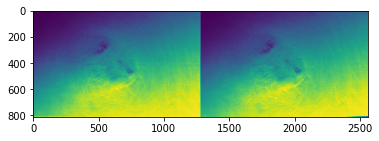

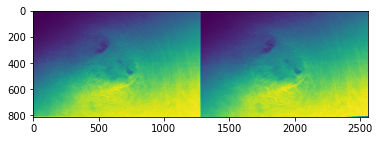

In [29]:
# Video Stabilization

import matplotlib
%matplotlib inline

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Reset stream to first frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ref = cv2.hconcat([prev_gray1, prev_gray1])
frames_out=np.zeros([h,w,n_frames])
plt.ion()
# Write n_frames-1 transformed frames
for i in range(n_frames):  # supposed to have -1
    print(i)
    # Read next frame
    success, frame = cap.read()
    if not success:
        break
    if i == 0:
      frame_fix = fixBorder(frame)
      frames_out[:,:,i] = cv2.cvtColor(frame_fix, cv2.COLOR_BGR2GRAY)
      #plt.imshow(cv2.equalizeHist(frame_fix))
    else:
      # Extract transformations from the new transformation array
      dx = transforms_smooth[i-1,0]
      dy = transforms_smooth[i-1,1]
      da = transforms_smooth[i-1,2]

      # Reconstruct transformation matrix accordingly to new values
      m = np.zeros((2,3), np.float32)
      m[0,0] = np.cos(da)
      m[0,1] = -np.sin(da)
      m[1,0] = np.sin(da)
      m[1,1] = np.cos(da)
      m[0,2] = dx
      m[1,2] = dy

      # Apply affine wrapping to the given frame
      frame_stabilized = cv2.warpAffine(frame, m, (w,h))

      # Fix border artifacts
      frame_stabilized = fixBorder(frame_stabilized)
      frames_out[:,:,i] = cv2.cvtColor(frame_stabilized, cv2.COLOR_BGR2GRAY)
      # Write the frame to the file
      frame_out = cv2.hconcat([frame, frame_stabilized])
      frame_out = cv2.cvtColor(frame_out, cv2.COLOR_BGR2GRAY)
      if is_ipython:
          display.clear_output(wait=True)
          display.display(plt.gcf())
      
      plt.imshow(cv2.equalizeHist(frame_out))
      #plt.imshow(np.abs(frame_out-ref))
      ref = frame_out
      # If the image is too big, resize it.
      if(frame_out.shape[1] > 1920):
          frame_out = cv2.resize(frame_out, (int(frame_out.shape[1]/2), int(frame_out.shape[0]/2)))
      #out.write(frame_out)

In [0]:
%cd /content/drive/My\ Drive/approach1_maskrcnn/stab
!pwd

In [0]:
# Save stabilized frames
for i in range(0,100):
  #print(i)
  img0 = frames_out[:,:,i]
  cv2.imwrite('%s.png' %i, img0)

In [0]:
# Transform the stabilized images to the required tiff file
from libtiff import TIFF
from scipy import misc
from PIL import Image
def image_array_to_tiff(image_dir, file_name, image_type, image_num):
 
    out_tiff = TIFF.open(file_name, mode = 'w')
	
    for i in range(0, image_num):
        image_name = image_dir + str(i) + image_type
        image_array = Image.open(image_name)
        out_tiff.write_image(image_array, compression = None, write_rgb = False)
		
    out_tiff.close()
    print('END!')
    return 


In [0]:
%cd /content/drive/My\ Drive/approach1_maskrcnn

In [0]:
image_array_to_tiff('/content/drive/My Drive/approach1_maskrcnn/stab/', 'stab_val.tif', '.png', 100) # generate our test data after stabilization

END!


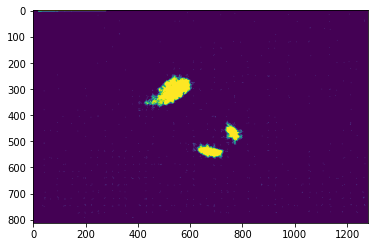

In [31]:
# Detect targeted region
diff=np.zeros(frames_out.shape[:2])
for i in range(1,100):
    diff += abs(frames_out[:,:,i]-frames_out[:,:,i-1])

diff1=np.copy(diff)
diff2=np.zeros([h,w])

diff1[diff<0.035*np.max(diff)]=0
diff1[diff1>0]=2
diff2[0:-20,20:-1]=diff1[0:-20,20:-1]

plt.imshow(diff2)

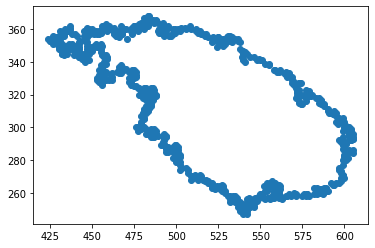

In [35]:
diff2_uint8 = np.uint8(diff2)
cont, hierarchy = cv2.findContours(diff2_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = []
for j in range(0,len(cont)):
  tmp_cont = cont[j]
  if len(tmp_cont) > 50:
      contours.append(tmp_cont)

o_con = contours[0]
for c in range(1,len(contours)):
  tmp_con = np.squeeze(contours[c])
  if len(tmp_con) > len(o_con):
    sel_con = tmp_con

plt.scatter(sel_con[:,0],sel_con[:,1])
plt.scatter()

In [85]:
# Find minimum bounding rectangle of the targeted region
minARec = cv2.minAreaRect(sel_con)
rec = cv2.boxPoints(minARec)
print(rec)

((517.2459106445312, 317.79510498046875),
 (189.62261962890625, 87.06507873535156),
 -39.80556869506836)

In [107]:
# Determine the ROI used for counting cells across the targed region
centroid = np.mean(sel_con,0)
print(centroid)
x_min, x_max = np.min(rec[:,0]), np.max(rec[:,0])
y_min, y_max = np.min(rec[:,1]), np.max(rec[:,1])

del_x = x_max - x_min
del_y = y_max - y_min
right=centroid[0] + del_x/2 
left=centroid[0] - del_x/2
up=centroid[1] + del_y/8
down=centroid[1] - del_y/8
cor_box = np.zeros((5,2))
cor_box.shape
cor_box[0,0], cor_box[0,1] = right, up
cor_box[1,0], cor_box[1,1] = right, down
cor_box[2,0], cor_box[2,1] = left, down
cor_box[3,0], cor_box[3,1] = left, up
cor_box[4,0], cor_box[4,1] = right, up


[510.4664981  315.73324905]


In [0]:
def Nrotate(angle,valuex,valuey,pointx,pointy):
 valuex = np.array(valuex)
 valuey = np.array(valuey)
 nRotatex = (valuex-pointx)*math.cos(angle) - (valuey-pointy)*math.sin(angle) + pointx
 nRotatey = (valuex-pointx)*math.sin(angle) + (valuey-pointy)*math.cos(angle) + pointy
 return nRotatex, nRotatey

In [0]:
cor_boxN = []
import math
for i in range(5):
  nx,ny = Nrotate(20,cor_box[i,0],cor_box[i,1],centroid[0],centroid[1])
  cor_boxN.append((nx,ny))
cor_boxN = np.array(cor_boxN)

[[530.07634271 417.27544901]
 [573.04837588 398.06716036]
 [490.85665349 214.19104909]
 [447.88462033 233.39933774]
 [530.07634271 417.27544901]]


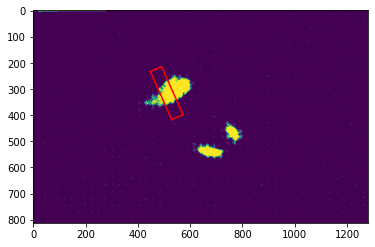

In [110]:
# checking

diff2_uint8 = np.uint8(diff2)
#plt.plot(cor_box[:,0],cor_box[:,1],color='red')
plt.plot(cor_boxN[:,0],cor_boxN[:,1],color='red')
plt.imshow(diff2_uint8)
print(cor_boxN) # cor_boxN: selected ROI used for counting cells